<center><h1>Kalman Net for fisheye videos</h1></center>

This is the central file for the kalman net for fisheye videos project.
The objective of this file is to:
1) Extract annotations
2) Add noise to annotations
    - Add noise
    - Remove some
3) Train kalman net
4) Test kalman net

In [1]:
#Dependencies
import torch

#Initialisation
torch.set_default_tensor_type('torch.FloatTensor')
device = torch.device("cpu")

if (torch.cuda.is_available() and False):
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0")

Extract annotations
-------------------

Current type of annotations: YOLOv8 (roboflow)

Data will be stored in list of lists of lists
- dim 0 : frames
- dim 1 : targets in that frame
- dim 2 : data of target -> [id, center_x, center_y, w, h]

positions and sizes will be normalized

In [2]:
#Dependencies
import glob

In [3]:
#Variables - source
data_source = "data/labels/" #Folder containing annotations
prefix_name = "image_" #Prefix to search with eg. image_12
sufix_name = "_jpg"
extension = ".txt"

In [4]:
#Load data into numpy array

data_store = []

#Temporary variables
c = 1

while True:
    files = glob.glob("./" + data_source + "*" + prefix_name + str(c) + sufix_name + "*" + extension)

    if(len(files) < 1):
        break
    elif(len(files) > 1):
        print("Too many files match frame, review your annotation source variables", files)
        break
    
    data_store.append([])

    with open(files[0], 'r') as f:
        lines = f.readlines()
        for l in lines:
            values = l.split(' ')
            data_store[-1].append([int(values[0])] + [float(v) for v in values[1:]])

    c += 1

Preprocess annotations
----------------------

Data flow:<br>
<i>Annotations</i> -> data_store [id, cx, cy, w, h] -> <i>Preprocess</i> data_store [path numb [cx, cy, w, h]]<br>
-> <i>Add noise</i> -> base_data + noisy_data [path numb [cx, cy, w, h]]

<h3>Separate by path</h3>

- Separated by target
- Separate by when target gets out of frame

In [5]:
new_store = []
followed_targets = [] #[t_num, ind, age]

def get_t_index(t):
    for tar in followed_targets:
        if tar[0] == t:
            return tar[1]
        
    new_store.append([])
    return len(new_store) - 1

for f in data_store:
    updated_followed_tars = []
    for l in f:
        ind = get_t_index(l[0])
        updated_followed_tars.append([l[0], ind])
        new_store[ind].append(l[1:])
    followed_targets = updated_followed_tars

data_store = sorted(new_store, key = len, reverse = True)

print("Number of paths: ", len(data_store))
for i in range(len(data_store[:5])):
    print("Path: ", i, " | Length:", len(data_store[i]))

Number of paths:  56
Path:  0  | Length: 999
Path:  1  | Length: 321
Path:  2  | Length: 225
Path:  3  | Length: 162
Path:  4  | Length: 103


<h3>Add noise</h3>

In [6]:
#Dependencies
import numpy as np

In [7]:
#Variables
noise_mean = 0
noise_std = 0.005

In [8]:
#backup base data
import copy
base_data = copy.deepcopy(data_store)

In [9]:
#Loop over entire data and add noise
for t in range(len(data_store)):
    for f in range(len(data_store[t])):
        for i in range(len(data_store[t][f])):
            data_store[t][f][i] += np.random.normal(loc = noise_mean, scale = noise_std)
noisy_data = data_store #Rename variable

Visualisation
-------------

Visualise trajectories on a graph

In [10]:
#Dependencies
import matplotlib.pyplot as plt

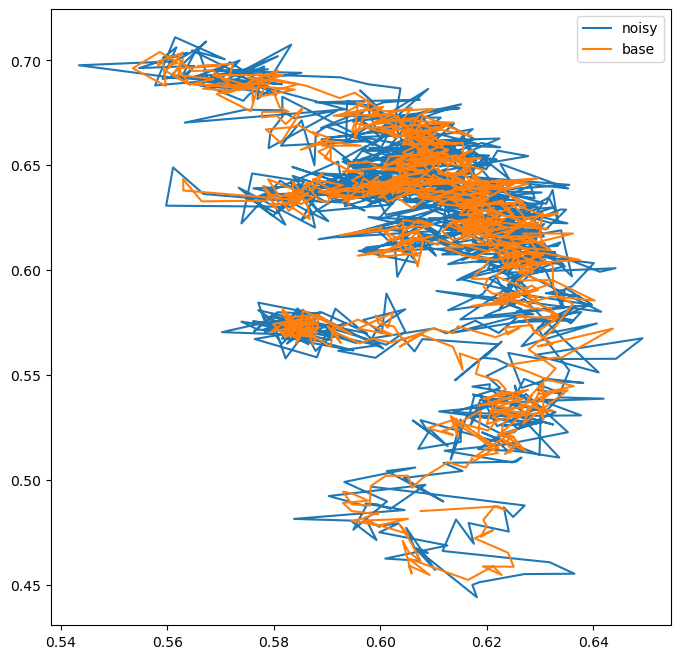

In [11]:
#Select section
id = 0

#Separating data
noise_values = [[], []]
base_values = [[], []]

for i in range(len(noisy_data[id])):
    f = base_data[id][i]
    f_noise = noisy_data[id][i]

    noise_values[0].append(sum([f_noise[0]]))
    noise_values[1].append(sum([f_noise[1]]))
    base_values[0].append(sum([f[0]]))
    base_values[1].append(sum([f[1]]))

#Plotting
fig, ax = plt.subplots(figsize=(8, 8))
#plt.xlim([0, 1])
#plt.ylim([0, 1])

plt.plot(noise_values[0], noise_values[1], label = "noisy")
plt.plot(base_values[0], base_values[1], label = "base")

plt.legend(loc="upper right")

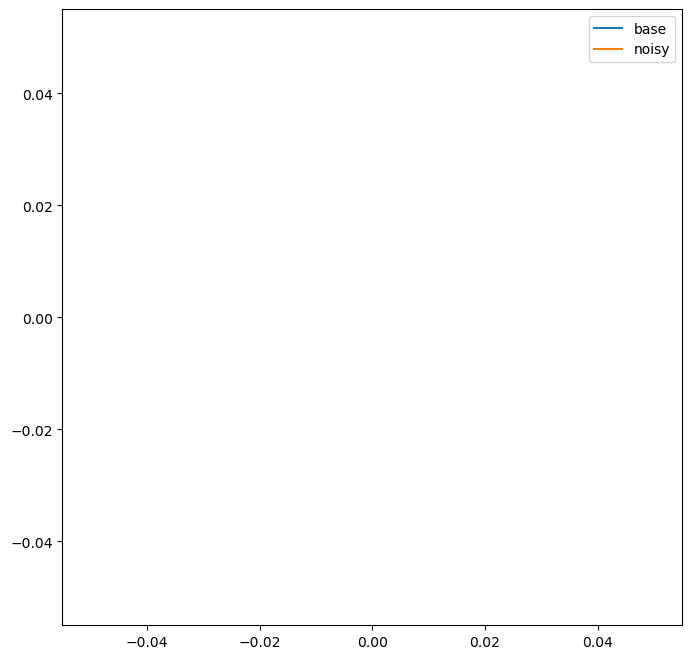

In [12]:
#Select id to follow (followed until first disappearance)
# id = 2

# #Separating data
# noise_values = [[], []]
# base_values = [[], []]

# for i in range(len(noisy_data)):
#     f = base_data[i]
#     f_noise = noisy_data[i]
#     if len(f) < 1 or all(t[0] != id for t in f):
#         break

#     noise_values[0].append(sum([t[1] if t[0] == id else 0 for t in f_noise]))
#     noise_values[1].append(sum([t[2] if t[0] == id else 0 for t in f_noise]))
#     base_values[0].append(sum([t[1] if t[0] == id else 0 for t in f]))
#     base_values[1].append(sum([t[2] if t[0] == id else 0 for t in f]))

# #Plotting
# fig, ax = plt.subplots(figsize=(8, 8))
# #plt.xlim([0, 1])
# #plt.ylim([0, 1])

# plt.plot(base_values[0], base_values[1], label = "base")
# plt.plot(noise_values[0], noise_values[1], label = "noisy")

# plt.legend(loc="upper right")

Training Kalman model
---------------------

Source: https://github.com/KalmanNet/KalmanNet_TSP

Learn to use the KalmanNet_nn module

<h3>Create Model</h3>

-   Define dynamics
-   Create System model
-   Create Knet Model
-   Create KNet Pipeline (System model, Knet model)

<u>Model</u><br>
State vector : [posx, posy, velx, vely]<br>
F :<br>
[[1, 0, dt, 0],<br>
[0, 1, 0, dt],<br>
[0, 0, 1, 0],<br>
[0, 0, 0, 1]]<br>

In [13]:
from Linear_sysmdl import SystemModel
from KalmanNet_nn import KalmanNetNN
from Pipeline_KF import Pipeline_KF

In [14]:
#Define system properties
#   Dynamic variables
dt = 1/20 #Time between measurements
F = torch.tensor([ #Dynamic model for movement
    [1, 0, 0, 0, dt, 0, 0, 0],
    [0, 1, 0, 0, 0, dt, 0, 0],
    [0, 0, 1, 0, 0, 0, dt, 0],
    [0, 0, 0, 1, 0, 0, 0, dt],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1]
])
#   View variables
H = torch.eye(8)
#   Noise variables
_r = 0.1 #?
v = 10**(-20 / 10) #ratio v = _q/_r
_q = v * _r #?
r, q = torch.sqrt(torch.tensor(_r)), torch.sqrt(torch.tensor(_q))
#   Sequence lengths | for training and testing - defines the length of the paths - why the fuck is it defined here? I don't know... will prob change it dinamically and pray for the best...
T = 100
T_test = 100

In [15]:
#Create system model
sys_model = SystemModel(F, q, H, r, T, T_test)

In [16]:
#Initialization sequence - for automatic data generation (maybe?)
m1_0 = torch.tensor([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])
m2_0 = 0 * 0 * torch.eye(8)

sys_model.InitSequence(m1_0, m2_0)

In [17]:
#Create NN model
KNet_model = KalmanNetNN()
KNet_model.Build(sys_model)

In [18]:
from datetime import datetime
today = datetime.today()
now = datetime.now()
strToday = today.strftime("%m.%d.%y")
strNow = now.strftime("%H:%M:%S")
strTime = strToday + "_" + strNow

#Create pipeline
KNet_Pipeline = Pipeline_KF(strTime, "KNet", "KNet_Network1.pt")
KNet_Pipeline.setssModel(sys_model)
KNet_Pipeline.setModel(KNet_model)

<h3>Preprocess data</h3>

- Format data
    - calculate velocity ([path [cx, cy, w, h]] -> [path [cx, cy, w, h, dcx, dcy, dw, dh]])
    - train, validate, test split
- Load data to torch

In [19]:
#Calculate velocity
#   Going to start with naive approach where velocity is determined exclusively from noisy for noisy and base for base

#Calculate velocity for base values
for i in range(len(base_data)):
    for r in range(len(base_data[i])):
        for j in range(len(base_data[i][r])):
            base_data[i][r].append( (base_data[i][r][j] - base_data[i][max(0, r - 1)][j]) / dt)

#Calculate velocity for noisy values
for i in range(len(noisy_data)):
    for r in range(len(noisy_data[i])):
        for j in range(len(noisy_data[i][r])):
            noisy_data[i][r].append( (noisy_data[i][r][j] - noisy_data[i][max(0, r - 1)][j]) / dt)

In [20]:
#Remove paths that are too short - assumption -> both arrays have already been sorted (big to small) and have the same length
cutoff = 10
cutoff_index = len(base_data) + 1

for i in range(len(base_data)):
    if len(base_data[i]) < cutoff:
        cutoff_index = i + 1
        break

base_data = base_data[:cutoff_index]
noisy_data = noisy_data[:cutoff_index]

In [21]:
#Load data into torch + add appropriate dimension (n, t, 8) -> (n, 8, t)
#   Convert each path to torch Tensor and load to gpu TODO: load to gpu

base_data_tensors = []
for n in base_data:
    base_data_tensors.append( torch.transpose( torch.Tensor(n) , 0, 1 ).to(device) )

noisy_data_tensors = []
for n in noisy_data:
    noisy_data_tensors.append( torch.transpose( torch.Tensor(n) , 0, 1 ).to(device) )


if False:
    #Load data into torch + add appropriate dimension (n, t, 8) -> (n, t, 8, 1)
    #   Convert each path to torch Tensor and load to gpu TODO: load to gpu

    base_data_tensors = []
    for n in base_data:
        base_data_tensors.append(torch.Tensor(n)[:, :, None].to(device))

    noisy_data_tensors = []
    for n in noisy_data:
        noisy_data_tensors.append(torch.Tensor(n)[:, :, None].to(device))

In [22]:
from sklearn.model_selection import train_test_split

#train, validate, test split
X_train, X_val, y_train, y_val  = train_test_split(noisy_data_tensors, base_data_tensors, test_size=0.8, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, shuffle=False)

print("\nTrain {} elements | Validate {} elements | Test {} elements".format(len(X_train), len(X_val), len(X_test)))
print(" {} elements |   {} elements   | {} elements".format(sum([len(v) for v in X_train]), sum([len(v) for v in X_val]), sum([len(v) for v in X_test])))


Train 5 elements | Validate 18 elements | Test 6 elements
 40 elements |   144 elements   | 48 elements


<h3>Train neural network</h3>

In [23]:
#Set training parameters
KNet_Pipeline.setTrainingParams(n_Epochs=500, n_Batch=30, learningRate=1E-3, weightDecay=1E-5)

In [24]:
X_train[0].shape

torch.Size([8, 999])

In [25]:
#First attempt with single tensor

KNet_Pipeline.setTrainingParams(n_Epochs=10, n_Batch=10, learningRate=1E-3, weightDecay=1E-5)

# x_train_in = torch.Tensor([base_data[0]])
# y_train_in = torch.Tensor([noisy_data[0]])
# x_val_in = torch.Tensor([base_data[1]])
# y_val_in = torch.Tensor([noisy_data[1]])

new_T = 300

x_train_in = X_train[0][None, :, :new_T].to(device)
y_train_in = y_train[0][None, :, :new_T].to(device)
x_val_in = X_train[1][None, :, :new_T].to(device)
y_val_in = y_train[1][None, :, :new_T].to(device)

N_E = x_train_in.shape[0] #should equal 1 rn
N_CV = x_val_in.shape[0] #should equal 1 rn

#Change sequence lengths, temporary fix
KNet_Pipeline.ssModel.T = new_T

KNet_Pipeline.NNTrain(N_E, x_train_in, y_train_in, N_CV, x_val_in, y_val_in)

0 MSE Training : tensor(101.3727) [dB] MSE Validation : tensor(106.5755) [dB]
Optimal idx: 0 Optimal : tensor(106.5755) [dB]


In [ ]:
KNet_Pipeline.save()

: 

In [ ]:
N_E = len(X_train) #Number of training examples
N_CV = len(X_val) #Number of cross-validation examples

KNet_Pipeline.NNTrain(N_E, X_train, y_train, N_CV, X_val, y_val)

: 

<h3>Testing and Visualizing</h3>

In [ ]:
#Running network
N_T = x_train_in.shape[0]

x_test_in = X_train[0][None, :, :new_T].to(device)
y_test_in = y_train[0][None, :, :new_T].to(device)

#Change sequence lengths, temporary fix
KNet_Pipeline.ssModel.T = new_T

[KNet_MSE_test_linear_arr, KNet_MSE_test_linear_avg, KNet_MSE_test_dB_avg, KNet_test] = KNet_Pipeline.NNTest(N_T, x_test_in, y_test_in)

KNet_Network1.pt-MSE Test: tensor(-14.9717) [dB]
KNet_Network1.pt-STD Test: tensor(nan) [dB]
Inference Time: 0.9569897651672363


C:\Users\benoi\AppData\Local\Temp\ipykernel_9176\1921686432.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


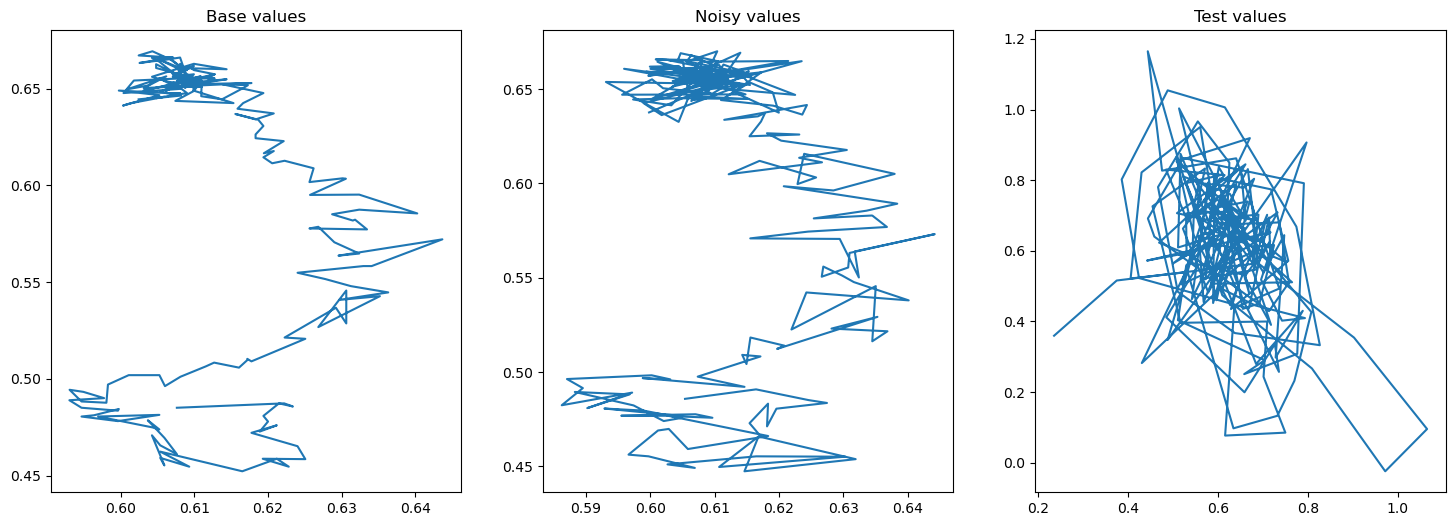

In [ ]:
model_test_values = torch.transpose(KNet_test, 0, 1).detach().numpy()

#Plotting
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# plt.xlim([0, 1])
# plt.ylim([0, 1])

axs[0].plot(base_values[0][:new_T], base_values[1][:new_T])
axs[0].set_title("Base values")

axs[1].plot(noise_values[0][:new_T], noise_values[1][:new_T])
axs[1].set_title("Noisy values")

axs[2].plot(model_test_values[:, 0], model_test_values[:, 1])
axs[2].set_title("Test values")

# plt.plot(noise_values[0], noise_values[1], label = "noisy")
# plt.plot(base_values[0], base_values[1], label = "base")

fig.show()